# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [2]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [2]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        assert self.gd_type in [
            "full",
            "stochastic",
        ], "gd_type={} not supported!".format(self.gd_type)

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        self.loss_history = []

        if self.w0 is None:
          self.w = np.random.rand(X.shape[1])
        else:
          self.w = self.w0

        for i in range(self.max_iter):

          self.loss_history.append(self.calc_loss(X, y))

          w_prev = self.w.copy()

          if self.gd_type == 'stochastic':

            j = np.random.randint(0, len(X) - 1)
            grad = self.calc_gradient(X[j].reshape(1, -1), np.array([y[j]]))
            self.w -= self.eta * grad

          elif self.gd_type == 'full':

            grad = self.calc_gradient(X, y)
            self.w -= self.eta * grad

          if np.linalg.norm(self.w - w_prev) < self.tolerance:
            break

        return self


    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        if X.shape[1] + 1 == self.w.shape[0]:
                X = np.hstack((np.ones((X.shape[0], 1)), X))

        return 1 / (1 + np.exp(-X @ self.w))


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')

        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        proba = self.predict_proba(X)
        error = proba - y
        return X.T @ error / y.size

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        preds = self.predict_proba(X)
        epsilon = 1e-15
        return -np.mean(y * np.log(preds + epsilon) + (1 - y) * np.log(1 - preds + epsilon))

Теперь проверим работу вашего класса на синтетических данных.

In [3]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [4]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

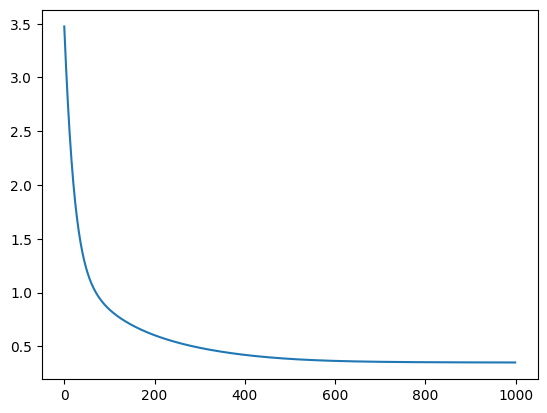

In [5]:
model_full = LogReg(gd_type='full')
model_full.fit(X_train, y_train)
plt.plot(model_full.loss_history)

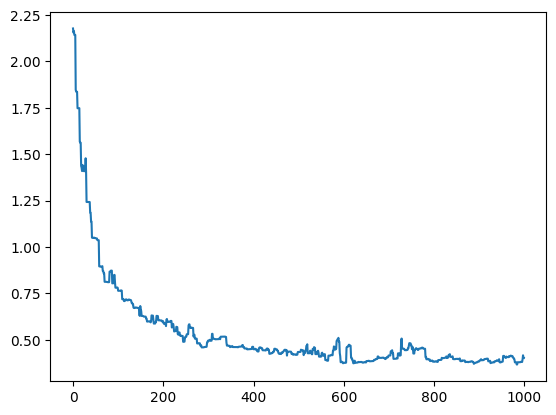

In [6]:
model_stochastic = LogReg(gd_type='stochastic', tolerance=1e-12)
model_stochastic.fit(X_train, y_train)
plt.plot(model_stochastic.loss_history)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [7]:
from sklearn.metrics import precision_recall_curve

In [8]:
y_test_prob = model_full.predict_proba(X_test)

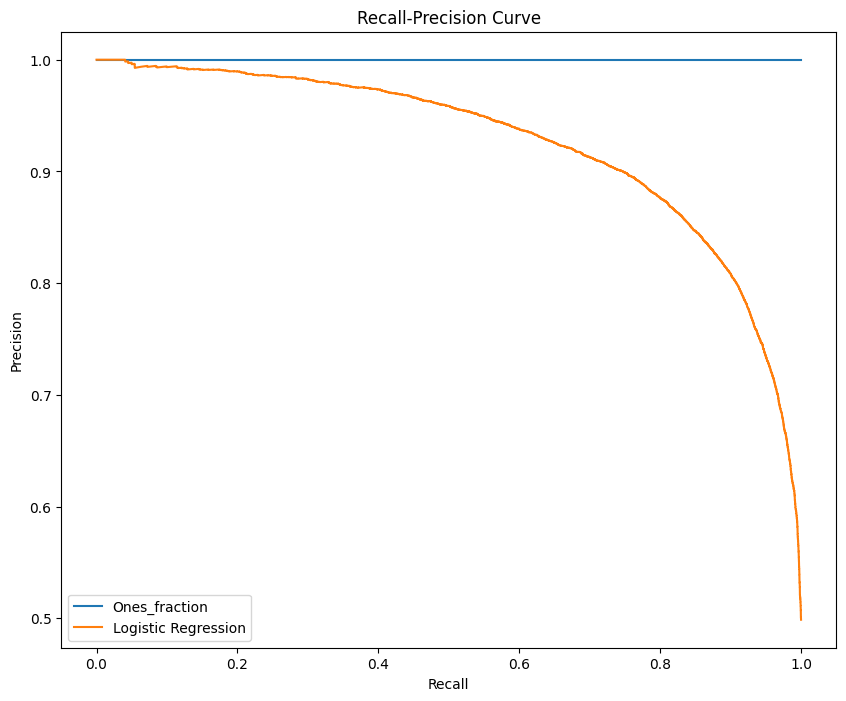

In [9]:
ones_fraction = len(y==1)/len(y)

plt.figure(figsize=(10,8))
plt.plot([0,1],[ones_fraction, ones_fraction], label="Ones_fraction")

precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
plt.plot(recall, precision, marker='', label="Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Recall-Precision Curve")
plt.legend()
plt.show()

По r-p кривой можно сказать, что модель достигает достаточно высокой точности и полноты

In [10]:
from sklearn import metrics

auc_score = metrics.auc(recall, precision) * 100
print('Logistic PR-AUC: %.3f' % auc_score)

Logistic PR-AUC: 92.528


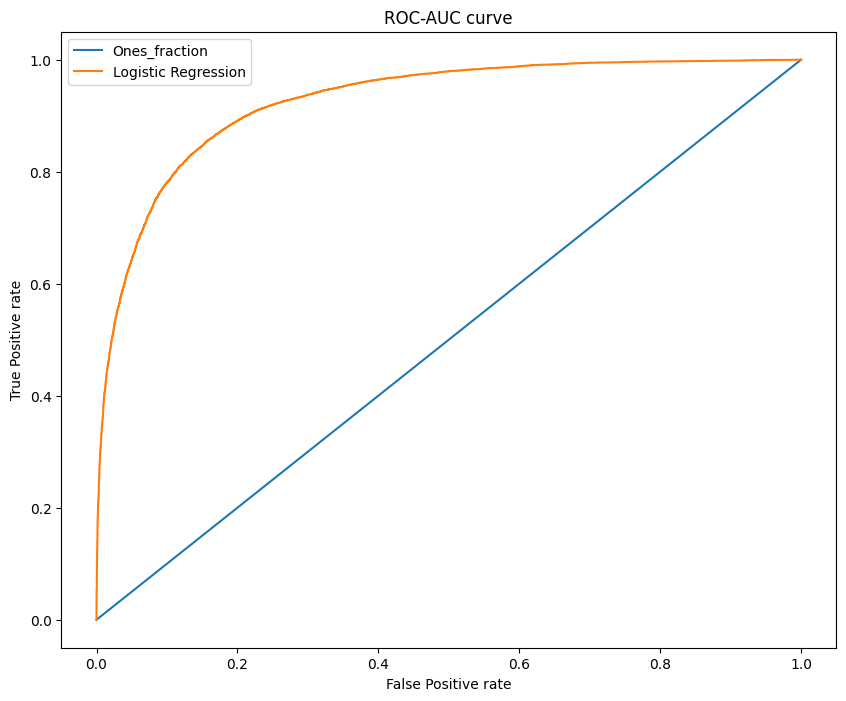

In [11]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10,8))
plt.plot([0,1],[0,1], label="Ones_fraction")
fpr, tpr,_ = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, marker='', label="Logistic Regression")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC-AUC curve")
plt.legend()
plt.show()

In [12]:
roc_score = metrics.roc_auc_score(y_test, y_test_prob) * 100
print('Logistic PR-AUC: %.3f'% roc_score)

Logistic PR-AUC: 92.577


# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
PATH_TO_DATASET = '/kaggle/input/train-csv/train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [5]:
cat_columns = [col for col in data.columns if col.endswith('cat')]
X_train = pd.get_dummies(X_train, columns=cat_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_columns, drop_first=True)
X_train.shape

(476169, 213)

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split

In [6]:
lr_model = LogisticRegression(max_iter=1000)
svm_model = SVC(kernel='linear', probability=True)
knn_model = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

In [20]:
%%time

lr_model.fit(X_train, y_train)

CPU times: user 2min 5s, sys: 12.7 s, total: 2min 18s
Wall time: 1min 31s


LogisticRegression(max_iter=1000)

In [21]:
y_pred_lr = lr_model.predict_proba(X_test)[:, 1]
roc_auc_lr = roc_auc_score(y_test, y_pred_lr)
roc_auc_lr

0.6381329998258148

In [9]:
%%time

knn_model.fit(X_train, y_train)

CPU times: user 928 ms, sys: 1.34 s, total: 2.27 s
Wall time: 3.86 s


KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [10]:
y_pred_knn = knn_model.predict_proba(X_test)[:, 1]
roc_auc_knn = roc_auc_score(y_test, y_pred_knn)
roc_auc_knn

0.5060661852272724

In [11]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

linear_svc = LinearSVC()
calibrated_svc = CalibratedClassifierCV(linear_svc)
calibrated_svc.fit(X_train, y_train)

CalibratedClassifierCV(estimator=LinearSVC())

In [13]:
y_pred_svc = calibrated_svc.predict_proba(X_test)[:, 1]
roc_auc_svc = roc_auc_score(y_test, y_pred_svc)
roc_auc_svc

0.6368420612861662

In [7]:
import time

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None, 'balanced']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, scoring='roc_auc', cv=5)

start_time = time.time()
grid_lr.fit(X_train, y_train)
end_time = time.time()

best_lr = grid_lr.best_estimator_

In [21]:
y_pred_lr_best = best_lr.predict_proba(X_test)[:, 1]
roc_auc_lr_best = roc_auc_score(y_test, y_pred_lr_best)

print(f"Лучшие параметры: {grid_lr.best_params_}, ROC-AUC: {roc_auc_lr_best:.4f}, Время обучения: {end_time - start_time:.2f} секунд")

Лучшие параметры: {'C': 0.01, 'class_weight': 'balanced'}, ROC-AUC: 0.6383, Время обучения: 4364.50 секунд


In [ ]:
linear_svc = LinearSVC()
calibrated_svc = CalibratedClassifierCV(linear_svc)
calibrated_svc.fit(X_train, y_train)

In [14]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    # 'kernel': ['linear', 'rbf'], #к сожалению в LinearSVC этого параметра нет, а на обучение простого SVC у меня нет времени (это много часов...........)
    'class_weight': [None, 'balanced']
}

grid_svm = GridSearchCV(LinearSVC(), param_grid_svm, scoring='roc_auc', cv=5)

start_time = time.time()
grid_svm.fit(X_train, y_train)
end_time = time.time()

In [18]:
best_svm = grid_svm.best_estimator_
y_pred_svm_best = best_svm.decision_function(X_test)
roc_auc_svm_best = roc_auc_score(y_test, y_pred_svm_best)

print(f"Лучшие параметры: {grid_svm.best_params_}, ROC-AUC: {roc_auc_svm_best:.4f}, Время обучения: {end_time - start_time:.2f} секунд")

Лучшие параметры: {'C': 0.1, 'class_weight': 'balanced'}, ROC-AUC: 0.6381, Время обучения: 4423.65 секунд


In [ ]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7], #больше не хочу пробовать, оч долго будет(((((((
    'weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring='roc_auc', cv=5)

start_time = time.time()
grid_knn.fit(X_train, y_train)
end_time = time.time()

In [11]:
best_knn = grid_knn.best_estimator_
y_pred_knn_best = best_knn.predict_proba(X_test)[:, 1]
roc_auc_knn_best = roc_auc_score(y_test, y_pred_knn_best)

print(f"Лучшие параметры: {grid_knn.best_params_}, ROC-AUC: {roc_auc_knn_best:.4f}")

Лучшие параметры: 3, ROC-AUC: 0.5061


### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [5]:
from sklearn.preprocessing import StandardScaler

In [17]:
%%time

model = LogisticRegression(max_iter=1000, C=0.01, class_weight='balanced')
model.fit(X_train, y_train)

importance = np.abs(model.coef_).flatten()  
top_150_indices = np.argsort(importance)[-150:] 

CPU times: user 6min 6s, sys: 1min, total: 7min 7s
Wall time: 1min 51s


In [18]:
X_train_selected = X_train.to_numpy()[:, top_150_indices]
X_test_selected = X_test.to_numpy()[:, top_150_indices]

print(f"Кол-во выбранных признаков: {X_train_selected.shape[1]}")

Кол-во выбранных признаков: 150


In [20]:
model_2 = LogisticRegression(max_iter=1000, C=0.01, class_weight='balanced')
model_2.fit(X_train_selected, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000)

In [21]:
y_pred = model_2.predict_proba(X_test_selected)[:, 1]
roc_auc_model_2 = roc_auc_score(y_test, y_pred)

print(f"Точность модели на 150 признаках без скалирования: {roc_auc_model_2:.4f}")

Точность модели на 150 признаках без скалирования: 0.6361


In [22]:
binary_columns = [col for col in X_train.columns if set(X_train[col].unique()).issubset({0, 1})]

categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

columns_to_scale = [col for col in X_train.columns if col not in binary_columns + categorical_columns]

num_features_to_scale = len(columns_to_scale)
print(f"Количество признаков, которые будут масштабированы: {num_features_to_scale}")

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

Количество признаков, которые будут масштабированы: 26


In [23]:
X_train_selected_scaled = X_train_scaled.to_numpy()[:, top_150_indices]
X_test_selected_scaled = X_test_scaled.to_numpy()[:, top_150_indices]

print(f"Кол-во выбранных признаков: {X_train_selected_scaled.shape[1]}")

Кол-во выбранных признаков: 150


In [24]:
model_3 = LogisticRegression(max_iter=1000, C=0.01, class_weight='balanced')
model_3.fit(X_train_selected_scaled, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000)

In [25]:
y_pred = model_3.predict_proba(X_test_selected_scaled)[:, 1]
roc_auc_model_3 = roc_auc_score(y_test, y_pred)

print(f"Точность модели на 150 признаках co скалированием: {roc_auc_model_3:.4f}")

Точность модели на 150 признаках co скалированием: 0.6362


### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [41]:
%%time

log_reg = LogisticRegression(max_iter=1000, C=0.01, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

feature_importances = abs(log_reg.coef_[0])
top_200_indices = feature_importances.argsort()[-200:]

X_train_200 = X_train_scaled.iloc[:, top_200_indices]
X_test_200 = X_test_scaled.iloc[:, top_200_indices]

print(f"Отобрано {X_train_200.shape[1]} признаков на первом этапе.")

log_reg = LogisticRegression(max_iter=1000, C=0.01, class_weight='balanced')
log_reg.fit(X_train_200, y_train)

feature_importances_200 = abs(log_reg.coef_[0])
top_150_indices = feature_importances_200.argsort()[-150:]

X_train_150 = X_train_200.iloc[:, top_150_indices]
X_test_150 = X_test_200.iloc[:, top_150_indices]

print(f"Отобрано {X_train_150.shape[1]} признаков на втором этапе.")

Отобрано 200 признаков на первом этапе.
Отобрано 150 признаков на втором этапе.
CPU times: user 3min 55s, sys: 41.8 s, total: 4min 37s
Wall time: 1min 13s


In [28]:
model_4 = LogisticRegression(max_iter=1000, C=0.01, class_weight='balanced')
model_4.fit(X_train_150, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=1000)

In [29]:
y_pred = model_4.predict_proba(X_test_150)[:, 1]
roc_auc_model_4 = roc_auc_score(y_test, y_pred)

print(f"Точность модели на 150 признаках: {roc_auc_model_4:.4f}")

Точность модели на 150 признаках: 0.6385


### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [6]:
from sklearn.linear_model import Lasso

In [31]:
param_grid = {'alpha': [0.1, 1, 10, 100]}  # Alpha = 1 / C
lasso = Lasso(max_iter=1000)
grid_search = GridSearchCV(lasso, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(), param_grid={'alpha': [0.1, 1, 10, 100]},
             scoring='roc_auc')

In [32]:
best_model = grid_search.best_estimator_
print(f"Лучшее значение alpha: {grid_search.best_params_['alpha']}")

coefficients = best_model.coef_
nonzero_weights = (coefficients != 0).sum()
print(f"Число ненулевых весов: {nonzero_weights}")

rounded_weights = (coefficients.round(2) != 0).sum()
print(f"Число ненулевых весов после округления: {rounded_weights}")

if rounded_weights >= 150:
    print("Удалось отобрать 150 признаков.")
else:
    print("Не удалось отобрать 150 признаков.")

Лучшее значение alpha: 0.1
Число ненулевых весов: 0
Число ненулевых весов после округления: 0
Не удалось отобрать 150 признаков.


Удалось ли отобрать 150 признаков за 1 шаг?
не удалось

### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [34]:
%%time

t_stats = {}
for col in X_train_scaled.columns:
    group_1 = X_train_scaled[y_train == 1][col]
    group_0 = X_train_scaled[y_train == 0][col]
    
    # Среднее и стандартное отклонение для каждого класса
    mu_plus = group_1.mean()
    mu_minus = group_0.mean()
    s_plus = group_1.std()
    s_minus = group_0.std()
    n_plus = len(group_1)
    n_minus = len(group_0)
    
    # t-статистика
    t_stat = abs(mu_plus - mu_minus) / np.sqrt((s_plus**2 / n_plus) + (s_minus**2 / n_minus))
    t_stats[col] = t_stat

# Сортируем признаки по t-статистике и оставляем половину
t_stats_sorted = sorted(t_stats.items(), key=lambda x: x[1], reverse=True)
selected_cols = [col for col, _ in t_stats_sorted[:len(t_stats_sorted)//2]]

CPU times: user 39.2 s, sys: 14.1 s, total: 53.3 s
Wall time: 53.4 s


In [37]:
X_train_selected = X_train_scaled[selected_cols]
X_test_selected = X_test_scaled[selected_cols]

model = LogisticRegression(max_iter=10000, C=0.01, class_weight='balanced')
model.fit(X_train_selected, y_train)
y_pred = model.predict_proba(X_test_selected)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred)
print(f"roc_auc модели: {roc_auc:.4f}")

roc_auc модели: 0.6387


### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

## Метод 1: Встроенный метод (основанный на весах модели)
Описание: Используется логистическая регрессия. Признаки отбираются на основе модулей весов после обучения модели.

### 1.1 Прямой отбор 150 признаков:

Точность:
Без скалирования: 0.6361
С скалированием: 0.6362
Wall time: 1 мин 51 с
1.2 Итеративный отбор (200 → 150 признаков):

Точность: 0.6385
Wall time: 1 мин 13 с
Преимущества:

- Простота реализации.
- Быстрая интерпретация важности признаков благодаря весам.
- Подходит для больших данных.

Недостатки:

- Зависимость от используемой модели (только линейные модели).
- Не учитывает взаимозависимости между признаками.
- Увеличение времени при итеративном подходе.

## Метод 2: L1-регуляризация
Описание:
Используется L1-регуляризация, которая добавляет штраф за ненулевые веса модели. Признаки с малыми весами обнуляются, что автоматически исключает их из модели.

Результаты:

Wall time: Не указано.
Вывод: Не удалось отобрать 150 признаков за 1 шаг.

Преимущества:

- Способность отбирать признаки встроена в модель.
- Учитывает взаимозависимости между признаками.

Недостатки:

- Требуется тщательная настройка коэффициента регуляризации C
- Может игнорировать слабые, но важные признаки.

## Метод 3: Фильтрационные методы (Filter methods)
Описание:
Признаки оцениваются на основе t-статистики, которая измеряет разницу между средними значениями для классов. Отбираются признаки с наибольшими значениями статистики.

Результаты:

Точность: roc_auc = 0.6387
Wall time: 53.4 с
Преимущества:

- Простота и независимость от модели.
- Быстрое вычисление.
- Учитывает различия между классами.

Недостатки:

- Игнорирует взаимодействие между признаками.
- Зависит от корректности предположений (независимость данных, нормальность распределений).

Выводы
Лучшее качество (roc_auc = 0.6387) показал метод фильтрации на основе t-статистики.
Быстрее всего оказался фильтрационный метод (53.4 с).
Итеративный метод (встроенный через веса модели) дает качество немного ниже (0.6385), но также остается эффективным.

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [7]:
from sklearn.model_selection import train_test_split

PATH = '/kaggle/input/nlp-getting-started/train.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [43]:
missing_info = data.isnull().sum()
print("Пропуски в данных:\n", missing_info)

Пропуски в данных:
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [8]:
data.fillna('', inplace=True)

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [45]:
numeric_columns = data.select_dtypes(include=['number']).columns
unique_values = {col: data[col].nunique() for col in numeric_columns}
print("\nУникальные значения в числовых столбцах:", unique_values)


Уникальные значения в числовых столбцах: {'id': 7613, 'target': 2}


- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [46]:
class_counts = data['target'].value_counts(normalize=True)
print("\nСоотношение классов в целевой переменной:\n", class_counts)


Соотношение классов в целевой переменной:
 target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [9]:
data['text_combined'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']
data

,id,keyword,location,text,target,text_combined
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake...
1,4,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' ar...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation ..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska a...
...,...,...,...,...,...,...
7608,10869,,,Two giant cranes holding a bridge collapse int...,1,Two giant cranes holding a bridge collapse i...
7609,10870,,,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @TheTawniest The out of control...
7610,10871,,,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. h...
7611,10872,,,Police investigating after an e-bike collided ...,1,Police investigating after an e-bike collide...


- Наконец, поделите данные на тренировочную и тестовую выборки.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data['text_combined'], data['target'], 
                                                    test_size=0.2, random_state=42, stratify=data['target'])

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [49]:
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

In [50]:
print("Размер матрицы признаков после CountVectorizer:", X_train_counts.shape)

Размер матрицы признаков после CountVectorizer: (6090, 20190)


- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [51]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_counts, y_train)
y_pred_log_reg = log_reg.predict(X_test_counts)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print("F1-скор логистической регрессии:", f1_log_reg)


F1-скор логистической регрессии: 0.7724784988272089


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [52]:
svc = SVC(random_state=42)
svc.fit(X_train_counts, y_train)
y_pred_svc = svc.predict(X_test_counts)
f1_svc = f1_score(y_test, y_pred_svc)

print("F1-скор SVC:", f1_svc)

F1-скор SVC: 0.7500000000000001


### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [53]:
vectorizer_tuned = CountVectorizer(max_df=0.7, min_df=5, max_features=int(len(X_train) / 4))
X_train_tuned = vectorizer_tuned.fit_transform(X_train)
X_test_tuned = vectorizer_tuned.transform(X_test)

print("Размер матрицы признаков после настройки гиперпараметров:", X_train_tuned.shape)


Размер матрицы признаков после настройки гиперпараметров: (6090, 1522)


In [54]:
# Обучение SVC на новых данных
svc.fit(X_train_tuned, y_train)
y_pred_svc_tuned = svc.predict(X_test_tuned)
f1_svc_tuned = f1_score(y_test, y_pred_svc_tuned)
print("F1-скор SVC (тюнинг CountVectorizer):", f1_svc_tuned)

F1-скор SVC (тюнинг CountVectorizer): 0.7508361204013378


In [55]:
# Обучение логистической регрессии на новых данных
log_reg.fit(X_train_tuned, y_train)
y_pred_log_reg_tuned = log_reg.predict(X_test_tuned)
f1_log_reg_tuned = f1_score(y_test, y_pred_log_reg_tuned)

print("F1-скор логистической регрессии (тюнинг CountVectorizer):", f1_log_reg_tuned)


F1-скор логистической регрессии (тюнинг CountVectorizer): 0.7653543307086614


### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [61]:
param_grid_log_reg = {'C': [0.01, 0.1, 1, 10], 'fit_intercept': [True, False]}
grid_log_reg = GridSearchCV(LogisticRegression(max_iter=10000, random_state=42), param_grid_log_reg, scoring='f1', cv=3)
grid_log_reg.fit(X_train_tuned, y_train)

print("Лучшие параметры для логистической регрессии:", grid_log_reg.best_params_)
print("Лучший F1-score для логистической регрессии:", grid_log_reg.best_score_)

Лучшие параметры для логистической регрессии: {'C': 0.1, 'fit_intercept': False}
Лучший F1-score для логистической регрессии: 0.7359856625356515


- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [62]:
param_grid_svc = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_svc = GridSearchCV(SVC(random_state=42), param_grid_svc, scoring='f1', cv=3)
grid_svc.fit(X_train_tuned, y_train)

print("Лучшие параметры для SVC:", grid_svc.best_params_)
print("Лучший F1-score для SVC:", grid_svc.best_score_)

Лучшие параметры для SVC: {'C': 0.1, 'kernel': 'linear'}
Лучший F1-score для SVC: 0.7331712920747556


### Подбор гиперпараметров для логистической регрессии и SVC

#### 1. Логистическая регрессия:

Для логистической регрессии были подобраны следующие гиперпараметры:

- C: Параметр регуляризации, который контролирует баланс между ошибкой на обучающих данных и сложностью модели. Меньшие значения означают более сильную регуляризацию.
  
- fit_intercept: Указывает, нужно ли добавлять свободный член в модель. Если False, модель будет проходить через начало координат.

#### 2. Подбор гиперпараметров для SVC:

Для модели SVC (Support Vector Classifier) были выбраны следующие гиперпараметры:

- C: Параметр, управляющий компромиссом между максимизацией зазора между классами и минимизацией классификационных ошибок. Меньшее значение делает модель более подверженной ошибкам, но менее склонной к переобучению.

- kernel: Функция ядра для преобразования данных в более высокое пространство для лучшего разделения. Линейное ядро (`linear`) подходит для линейных задач, а ядро Реба (RBF) применимо для более сложных (не линейных) задач.

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [13]:
from sklearn.pipeline import Pipeline

log_reg_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_df=0.7, min_df=5, max_features=int(len(X_train) / 4))),
    ('log_reg', LogisticRegression(C=0.1, fit_intercept=False))
])

svc_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_df=0.7, min_df=5, max_features=int(len(X_train) / 4))),
    ('svc', SVC(C=0.1, kernel='linear'))
])

log_reg_pipeline.fit(X_train, y_train)
svc_pipeline.fit(X_train, y_train)

y_pred_log_reg = log_reg_pipeline.predict(X_test)
y_pred_svc = svc_pipeline.predict(X_test)

f1_log_reg = f1_score(y_test, y_pred_log_reg)
f1_svc = f1_score(y_test, y_pred_svc)

print("F1-скор логистической регрессии (пайплайн):", f1_log_reg)
print("F1-скор SVC (пайплайн):", f1_svc)

F1-скор логистической регрессии (пайплайн): 0.7611026033690659
F1-скор SVC (пайплайн): 0.7702265372168285


### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

1. Предобработка данных:
   - На начальном этапе были выявлены пропуски в данных, которые были успешно заполнены пустыми строками. Это позволило обеспечить полноценную обработку данных без ошибок при обучении модели.
   - Также был проведен анализ данных, включающий изучение их структуры и содержания, что позволило правильно подготовить данные для векторизации и обучения моделей.

2. Базовые модели:
   - В качестве базового шага использовался CountVectorizer для преобразования текстовых данных в матрицу признаков. 
   - Были обучены две модели: логистическая регрессия и SVC. Результаты показали следующие значения F1-метрики:
     - Логистическая регрессия: 0.7725
     - SVC: 0.7500

3. Улучшение моделей через оптимизацию параметров CountVectorizer:
   - Подбор гиперпараметров для CountVectorizer позволил уменьшить количество признаков в 4 раза, при этом точность модели не ухудшилась существенно (изменение не более чем на ±0.07).
   - Результаты F1-метрики после тюнинга:
     - F1-скор для SVC (тюнинг CountVectorizer): 0.7508
     - F1-скор для логистической регрессии (тюнинг CountVectorizer): 0.7654

4. Подбор гиперпараметров для моделей:
   - Для логистической регрессии были подобраны следующие оптимальные параметры: 
     - C: 0.1
     - fit_intercept: False
   - Лучший F1-скор для логистической регрессии: 0.7360
   
   - Для модели SVC были подобраны следующие параметры:
     - C: 0.1
     - kernel: linear
   - Лучший F1-скор для SVC: 0.7332

### Итоги:
- Логистическая регрессия в целом показала более высокую точность по сравнению с SVC.
- Подбор гиперпараметров для CountVectorizer позволил значительно уменьшить количество признаков, что снизило сложность модели, но при этом не ухудшило ее качество.
- Оба метода, логистическая регрессия и SVC, показали достойные результаты, но дальнейшие улучшения могут быть возможны через более тонкую настройку гиперпараметров.

## Чей кот?

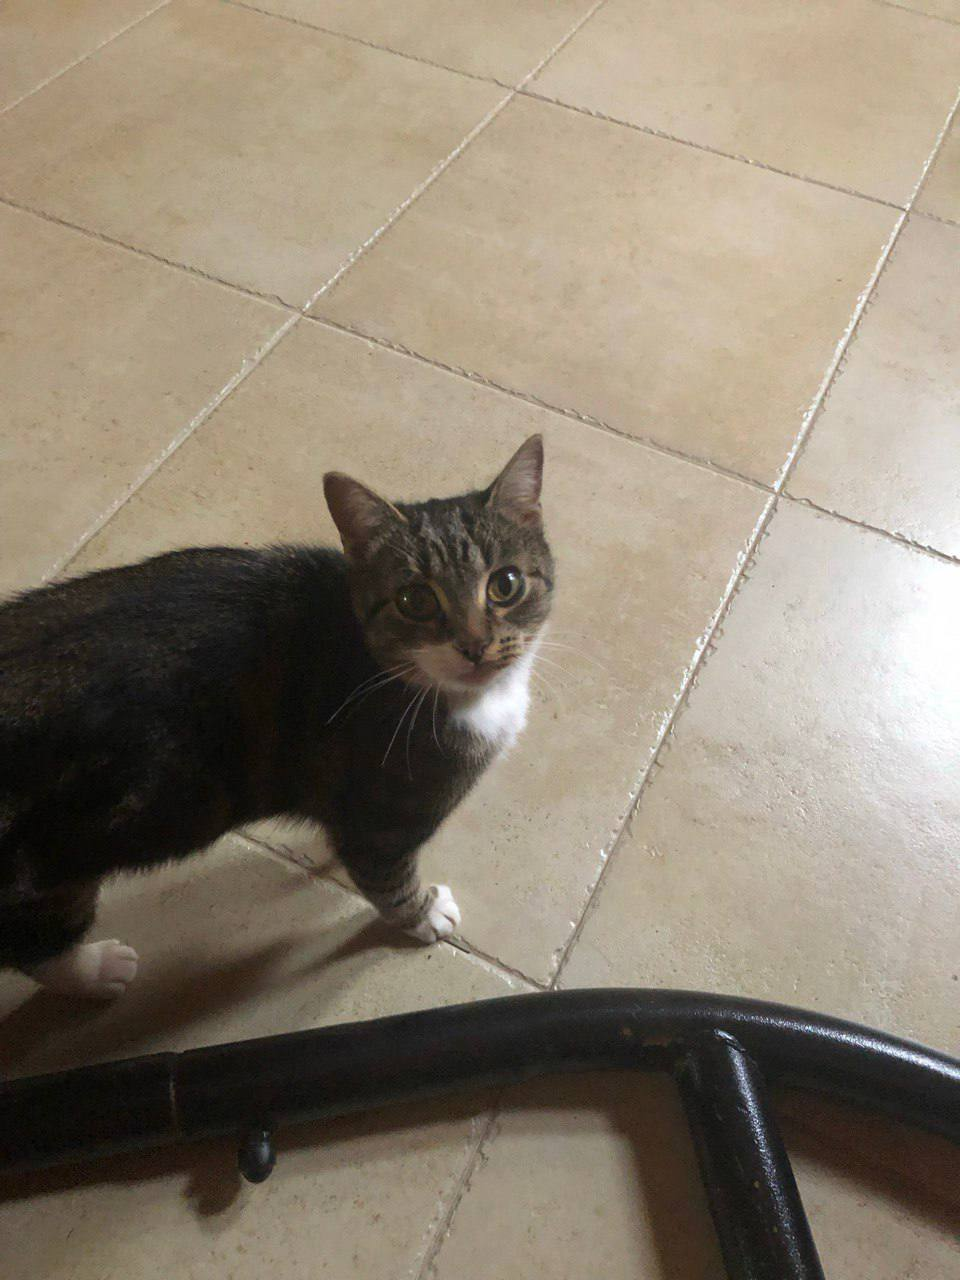

кот Сабрины?...